In [12]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error, f1_score

In [5]:
# Load a dataset into a Pandas DataFrame
proteins = pd.read_csv("train_proteins.csv")
peptides = pd.read_csv("train_peptides.csv")
clinical = pd.read_csv("train_clinical_data.csv")

In [6]:
protein = proteins.groupby(['visit_id','UniProt'])['NPX'].mean().reset_index()
peptide = peptides.groupby(['visit_id','Peptide'])['PeptideAbundance'].mean().reset_index()

# Step 2: Pivoting
df_protein = protein.pivot(index='visit_id',columns = 'UniProt', values = 'NPX').rename_axis(columns=None).reset_index()
df_peptide = peptide.pivot(index='visit_id',columns = 'Peptide', values = 'PeptideAbundance').rename_axis(columns=None).reset_index()

# Step 3: Merging
pro_pep_df = df_protein.merge(df_peptide, on = ['visit_id'], how = 'left').fillna(0)

merged_df = clinical.merge(pro_pep_df, on=['visit_id'], how='left').dropna()
merged_df.head()

,visit_id,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,upd23b_clinical_state_on_medication,O00391,O00533,...,YSLTYIYTGLSK,YTTEIIK,YVGGQEHFAHLLILR,YVM(UniMod_35)LPVADQDQC(UniMod_4)IR,YVMLPVADQDQC(UniMod_4)IR,YVNKEIQNAVNGVK,YWGVASFLQK,YYC(UniMod_4)FQGNQFLR,YYTYLIMNK,YYWGGQYTWDMAK
4,55_12,55,12,10.0,10.0,41.0,0.0,On,15257.6,815083.0,...,231772.0,17873.80,5474140.0,116286.0,711815.0,136943.0,181763.0,452253.0,54725.1,21841.1
8,55_36,55,36,17.0,18.0,51.0,0.0,On,13530.8,753832.0,...,185290.0,18580.50,2659660.0,90936.9,679163.0,128593.0,203680.0,498621.0,52792.7,13973.7
28,1517_0,1517,0,11.0,6.0,25.0,5.0,On,11648.9,419015.0,...,210259.0,6789.37,3956620.0,101069.0,767457.0,65663.2,113977.0,468234.0,44771.3,20695.0
32,1517_24,1517,24,19.0,11.0,28.0,3.0,On,11671.9,438138.0,...,218111.0,10053.50,3952000.0,152704.0,1079680.0,102169.0,129905.0,373894.0,58716.7,26098.3
34,1517_36,1517,36,20.0,17.0,31.0,8.0,On,10150.4,544208.0,...,194977.0,6669.14,3903420.0,78553.3,496351.0,67067.5,96201.7,351596.0,46628.7,13430.0


In [7]:
FEATURES = merged_df.iloc[:, 8:].columns.tolist()

# Train Model

In [8]:
# Define the SMAPE function
def smape(y_true, y_pred):
    return 2.0 * np.mean(np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

In [9]:
model = {}
target = ["updrs_1", "updrs_2", "updrs_3", "updrs_4"]

for u in target:
        
    # Drop NAs
    temp = clinical.dropna(subset=[u]) 
    
    # Train data
    X = temp['visit_month']
    y = temp[u]
        
    trained = LinearRegression().fit(X.values.reshape(-1, 1), y)
    
    # Save model
    model[u] = trained

updrs_1
Mean Squared Error (MSE): 18.42032446789638
Root Mean Squared Error (RMSE): 4.29189054705457
R-squared (R2): 0.41323868853442225
Symmetric Mean Absolute Percentage Error (SMAPE): 0.4349439904891524

updrs_2
Mean Squared Error (MSE): 17.473163413792516
Root Mean Squared Error (RMSE): 4.180091316441845
R-squared (R2): 0.454564872515946
Symmetric Mean Absolute Percentage Error (SMAPE): 0.40699076276108603

updrs_3
Mean Squared Error (MSE): 105.57046210307168
Root Mean Squared Error (RMSE): 10.27474876106816
R-squared (R2): 0.3967075119373994
Symmetric Mean Absolute Percentage Error (SMAPE): 0.3598549119909573

updrs_4
Mean Squared Error (MSE): 6.261136149477424
Root Mean Squared Error (RMSE): 2.5022262386677636
R-squared (R2): 0.4250536291406728
Symmetric Mean Absolute Percentage Error (SMAPE): 1.2839198406060732



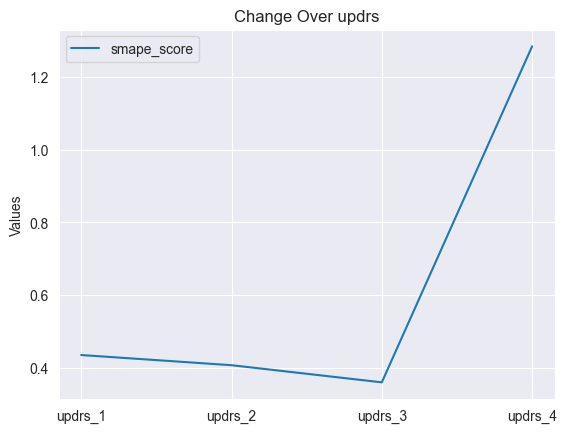

In [26]:
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
rf_model = {}
target = ["updrs_1", "updrs_2", "updrs_3", "updrs_4"]
mse_list = []
rmse_list = []
r2_list = []
smape_score_list = []
for u in target:

    # Drop NAs
    temp = merged_df.dropna(subset=[u]).copy()

    # Predict using LinReg
    X = temp['visit_month']
    temp["preds"] = np.ceil(model[u].predict(X.values.reshape(-1, 1)))

    X = temp[FEATURES + ['preds']]
    y = temp[u]

    rf  = RandomForestRegressor(max_depth=3, n_estimators=100, random_state=0)
    rf.fit(X, y)

    # Save model
    rf_model[u] = rf

    y_pred = rf_model[u].predict(X)

    # Mean Squared Error (MSE)
    mse = mean_squared_error(y, y_pred)

    # Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mse)


    # R-squared (R2)
    r2 = r2_score(y, y_pred)

    # Symmetric Mean Absolute Percentage Error (SMAPE)
    smape_score = smape(y, y_pred)


    # Print the results for the current model
    print(u)
    print("Mean Squared Error (MSE):", mse)
    print("Root Mean Squared Error (RMSE):", rmse)
    print("R-squared (R2):", r2)
    print("Symmetric Mean Absolute Percentage Error (SMAPE):", smape_score)
    print()
    mse_list.append(mse)
    rmse_list.append(rmse)
    r2_list.append(r2)
    smape_score_list.append(smape_score)

metrics = ['MSE', 'RMSE', 'R2', 'SMAPE']

# 评估指标的值
values = [mse_list, rmse_list, r2_list, smape_score_list]
time_points = ['updrs_1', 'updrs_2', 'updrs_3', 'updrs_4']
# plt.plot(time_points, mse_list, label='mes')
# plt.plot(time_points, rmse_list, label='rmse')
# plt.plot(time_points, r2_list, label='r2')
plt.plot(time_points, smape_score_list, label='smape_score')

# 添加标签
plt.ylabel('Values')
plt.title('Change Over updrs')
plt.legend()

# 显示图形
plt.show()


In [10]:
xgb_model = {}
target = ["updrs_1", "updrs_2", "updrs_3", "updrs_4"]

for u in target:
        
    # Drop NAs
    temp = merged_df.dropna(subset=[u]).copy()
    
    # Predict using LinReg
    X = temp['visit_month']
    temp["preds"] = np.ceil(model[u].predict(X.values.reshape(-1, 1)))
    
    X = temp[FEATURES + ['preds']]
    y = temp[u]
    
    xgb = XGBRegressor(max_depth=3, learning_rate=0.01, n_estimators=1000, tree_method='gpu_hist')
    xgb.fit(X, y)
    
    # Save model
    xgb_model[u] = xgb
    
    y_pred = xgb_model[u].predict(X)
    
    # Mean Squared Error (MSE)
    mse = mean_squared_error(y, y_pred)
    
    # Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mse)
    
    # R-squared (R2)
    r2 = r2_score(y, y_pred)
    
    # Symmetric Mean Absolute Percentage Error (SMAPE)
    smape_score = smape(y, y_pred)
    
    # Print the results for the current model
    print(u)
    print("Mean Squared Error (MSE):", mse)
    print("Root Mean Squared Error (RMSE):", rmse)
    print("R-squared (R2):", r2)
    print("Symmetric Mean Absolute Percentage Error (SMAPE):", smape_score)
    print()

NameError: name 'XGBRegressor' is not defined

# Predict

In [14]:
def get_predictions(my_train, model, model_1):

    # Forecast
    my_train = my_train.fillna(0)
    
    for u in target:
        
        # Here is where we will save the final results
        my_train['result_' + str(u)] = 0
        
        # Predict    
        X = my_train["visit_month"]
        
        #LinReg
        temp = my_train[FEATURES].copy()
        temp['preds'] = np.ceil(model[u].predict(X.values.reshape(-1, 1)))
        
        if u != 'updrs_4':
            mask = my_train[FEATURES].sum(axis=1) != 0
            my_train.loc[mask, 'result_' + str(u)] = model_1[u].predict(temp.loc[mask])
            my_train.loc[~mask, 'result_' + str(u)] = temp.loc[~mask, 'preds']
    
    # Format for final submission
    result = pd.DataFrame()

    for m in [0, 6, 12, 24]:
        for u in [1, 2, 3, 4]:

            temp = my_train[["visit_id", "result_updrs_" + str(u)]].copy()
            temp["prediction_id"] = temp["visit_id"] + "_updrs_" + str(u) + "_plus_" + str(m) + "_months"
            temp["rating"] = temp["result_updrs_" + str(u)]
            temp = temp [['prediction_id', 'rating']]

            result = result.append(temp)            
    result = result.drop_duplicates(subset=['prediction_id', 'rating'])

    return result

In [15]:
get_predictions(merged_df, model, xgb_model).head()

KeyError: 'updrs_1'

# Default Code to Submit Answers